In [1]:
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt

from utils import *
from collaborative_beamforming import *

In [2]:
side_of_region = 1000.
side_resolution = 20.
min_dist = 100
num_antennas = 20
wavelength = 1.

def place_antennas_around_station(station_position, distance_to_center=0.2, num_antennas=num_antennas):
    p = []
    angle_antennas = np.linspace(0, 2*np.pi, num_antennas)
    for angle in angle_antennas:
        p.append(station_position + distance_to_center * np.array([np.cos(angle), np.sin(angle)]))
    p = np.vstack(p)
    return p

In [3]:
station_positions = np.array([
    [side_of_region//2, min_dist],
    [min_dist, side_of_region//2],
    [side_of_region//2, side_of_region - min_dist]
])

antenna_positions = []
for s in station_positions:
    antenna_positions.append(place_antennas_around_station(s))

In [4]:
number_users = 100

norm_params = [

    # Closer to bottom antenna
    [np.array([side_of_region//2 - 100, min_dist + 80]), 20],
    [np.array([side_of_region//2 - 70, min_dist + 70]), 20],
    [np.array([side_of_region//2 + 150, min_dist + 65]), 20],

    # Closer to left antenna
    [np.array([min_dist + 140, side_of_region//2 + 50]), 20],
    [np.array([min_dist + 80, side_of_region//2 - 60]), 20],
    [np.array([min_dist + 140, side_of_region//2 + 40]), 20],

    # Closer to upper antenna
    [np.array([side_of_region//2 - 90, side_of_region - min_dist - 65]), 20],
    [np.array([side_of_region//2 + 70, side_of_region - min_dist - 80]), 20],
]
n_components = len(norm_params)
weights = np.ones(n_components, dtype=np.float64) / n_components
mixture_idx = np.random.choice(len(weights), size=number_users, replace=True, p=weights)
user_positions = np.array([ss.norm.rvs(*(norm_params[i])) for i in mixture_idx])

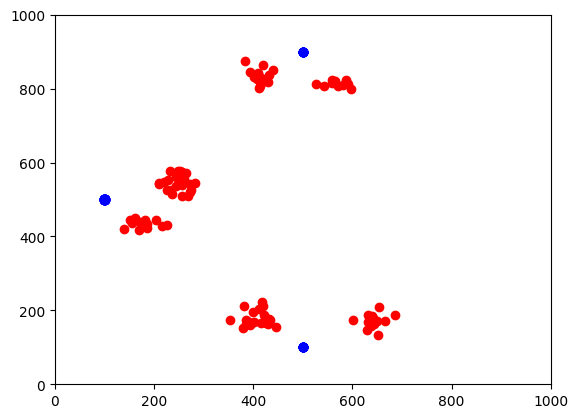

In [5]:
stacked_antenna_positions = np.vstack(antenna_positions)

plt.plot(stacked_antenna_positions[:,0],
         stacked_antenna_positions[:,1],
         'bo',
         user_positions[:,0],
         user_positions[:,1],
         'ro'
         )
plt.xlim(0, side_of_region)
plt.ylim(0, side_of_region)
plt.show()

In [6]:
cov_per_station = []
station_user_positions = []
for idx, ant in enumerate(antenna_positions):
    station_user_position = user_positions - station_positions[idx]
    station_user_position = (station_user_position.T/np.linalg.norm(station_user_position, axis=1)).T
    station_user_positions.append(station_user_position)
    cov_per_station.append(generate_covariance_matrix(ant, station_user_position, noise_level=1.))

In [7]:
steering_matrices = []
beamforming_weights = []
for s in range(len(antenna_positions)):
    steering_matrices.append(np.exp(-2 * np.pi * 1j * (antenna_positions[s] @ (station_user_positions[s]).T)))
    _, _, w_weights_s = flexibeam(antenna_positions[s] - station_positions[s],
                                  np.arccos(station_positions[s] @ station_user_positions[s].T/(np.linalg.norm(station_positions[s]))) * 360 / (2 * np.pi),
                                  20, wavelength)
    beamforming_weights.append(w_weights_s)

steering_matrix = np.vstack(steering_matrices)

beamforming_cols = []
zero_vector_length = len(beamforming_weights[0])
num_zero_vectors = len(beamforming_weights) - 1
for idx, w in enumerate(beamforming_weights):
    tmp = [np.zeros(zero_vector_length) for _ in range(num_zero_vectors)]
    tmp.insert(idx, w)
    beamforming_cols.append(np.array(tmp).reshape(-1, 1))
beamforming_matrix = np.hstack(beamforming_cols)

cov_of_stations = np.conj(beamforming_matrix).T @ steering_matrix @ np.diag(np.ones(len(user_positions))) @ np.conj(steering_matrix).T @ beamforming_matrix

In [8]:
closest_station_indices = []
for user in user_positions:
    closest_station_indices.append(np.argmin(np.linalg.norm(user - station_positions, axis=1)))

In [ ]:
beamforming_weights, thetas = collaborative_flexibeam(
    antenna_positions,
    station_positions,
    side_of_region,
    side_resolution,
    cov_per_station,
    cov_of_stations,
    4,
    wavelength=wavelength,
    num_iter=3000,
    lambda_=25,
    cluster_thresh=0
);

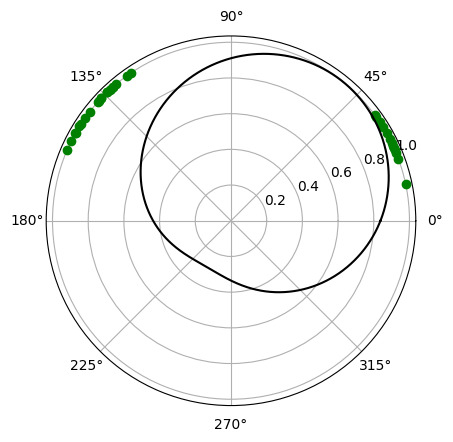

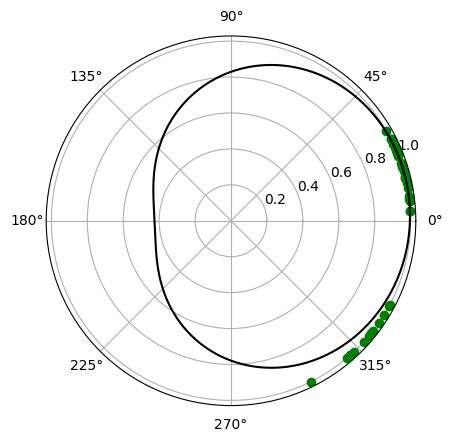

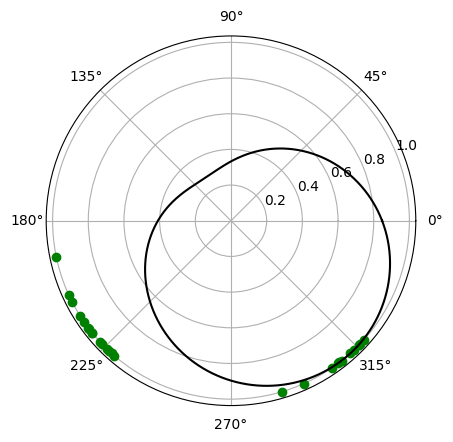

In [10]:
for s in range(len(beamforming_weights)):
    tmp = station_user_positions[s][np.isclose(closest_station_indices, s)]
    plt.polar(list(map(cartesian_to_arg, tmp)), np.ones(len(tmp)), "go", thetas[s], beamforming_weights[s]/np.max(beamforming_weights[s]), '-k')
    plt.show()